# Analising NiSi XRD data

In [1]:
import sys
print(sys.executable)

c:\Users\lhage\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

### read file

In [3]:
file_path = r"../Data/XRD/02172026_NiSi2_900grad_.xy"

data = pd.read_csv(file_path, delimiter=" ", skiprows=1, header=None, names=['Angle', 'Intensity'])

filename = os.path.basename(file_path)
name = filename.split("_", 1)[1].split("grad")[0]
print(name)

print(data.info())

NiSi2_900
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Angle      3001 non-null   float64
 1   Intensity  3001 non-null   float64
dtypes: float64(2)
memory usage: 47.0 KB
None


### plot basic spectra starting point

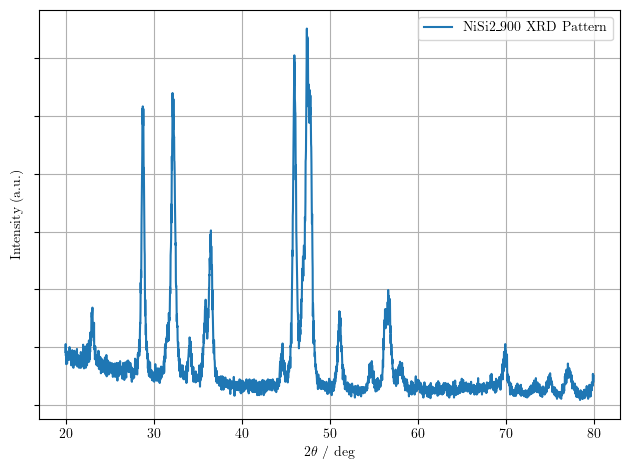

In [4]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['Intensity'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

## data processing
- remove background
- apply filter (Savitzky–Golay)
- normalise
- peak finding

In [5]:
# asymmetric least squares baseline correction
def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2), dtype=None)
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w,0,L,L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

### baseline correction

In [6]:
baseline = baseline_als(data['Intensity'].values)
data['Intensity_corr'] = data['Intensity'] - baseline

C:\Users\lhage\AppData\Local\Temp\ipykernel_10804\4060365311.py:9: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w*y)


### filter

In [7]:
data['filtered'] = signal.savgol_filter(data['Intensity_corr'], window_length=11, polyorder=3)

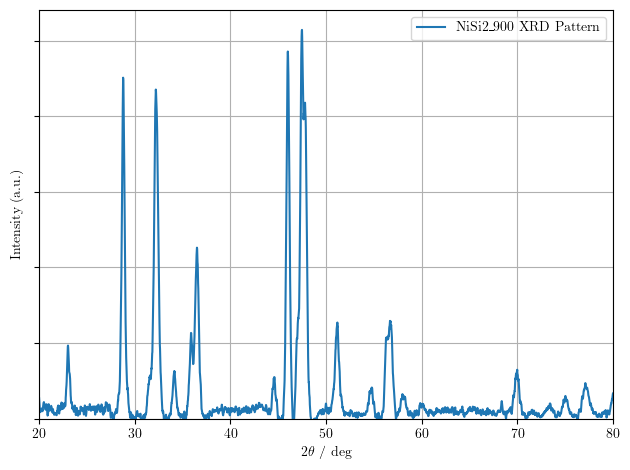

In [8]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['filtered'], label=f'{name} XRD Pattern')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

### normalise 

In [9]:
data['intensity_norm'] = data['filtered'] / data['filtered'].max()

### find peak position and height

In [10]:
# find peaks using scipy.signal.find_peaks
peaks, properties = signal.find_peaks(data['intensity_norm'], height=0.07, distance=10)
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [23.02 28.78 29.26 31.54 31.74 32.2  34.12 35.88 36.5  44.58 46.   47.08
 47.48 47.8  48.2  50.78 51.18 54.78 56.32 56.68 69.78 69.98 77.1 ]


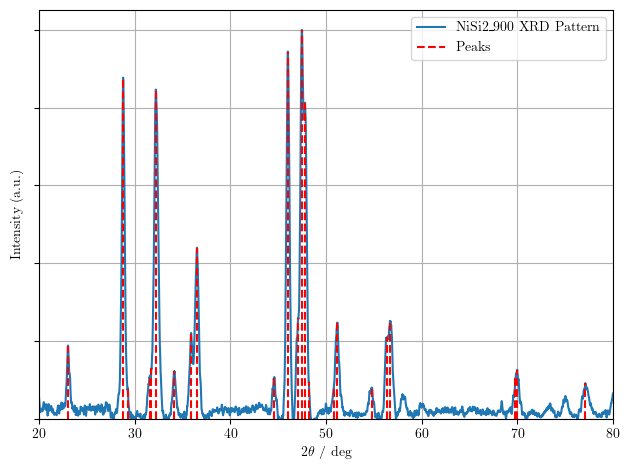

In [11]:
fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'], label=f'{name} XRD Pattern')

plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=0)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

In [12]:
print("Peaks found at angles:", data['Angle'].iloc[peaks].values)

Peaks found at angles: [23.02 28.78 29.26 31.54 31.74 32.2  34.12 35.88 36.5  44.58 46.   47.08
 47.48 47.8  48.2  50.78 51.18 54.78 56.32 56.68 69.78 69.98 77.1 ]


### lable peaks

In [13]:
NiSi2_peaks_index = [1, 13, 19, 20, 22]
NiSi2_peaks = data['Angle'].iloc[peaks[NiSi2_peaks_index]].values
print(NiSi2_peaks)

NiSi_peaks_index = [3, 6, 7, 8, 10, 12]
NiSi_peaks = data['Angle'].iloc[peaks[NiSi_peaks_index]].values
print(NiSi_peaks)

Ni2Si_peaks_index = [5, 17]
Ni2Si_peaks = data['Angle'].iloc[peaks[Ni2Si_peaks_index]].values
print(Ni2Si_peaks)

Ni_peaks_index = [9]
Ni_peaks = data['Angle'].iloc[peaks[Ni_peaks_index]].values
print(Ni_peaks)

[28.78 47.8  56.68 69.78 77.1 ]
[31.54 34.12 35.88 36.5  46.   47.48]
[32.2  54.78]
[44.58]


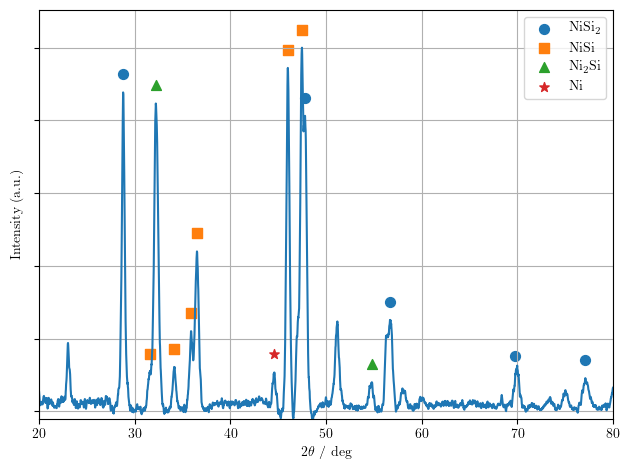

In [14]:
markers = {
    'NiSi2': 'o',  # Circle
    'NiSi': 's',   # Square
    'Ni2Si': '^',  # Triangle
    'Ni': '*'      # Star
}

def mark_peaks(ax, angles, intensities, marker, label):
    # Offset the marker slightly above the peak for clarity
    offset = 0.05 
    ax.scatter(angles, intensities + offset, marker=marker, label=label, s=50)


fig, ax = plt.subplots()

ax.plot(data['Angle'], data['intensity_norm'])

# plt.vlines(data['Angle'].iloc[peaks].values, ymin=0, ymax=data['intensity_norm'].iloc[peaks], color='red', linestyle='--', label='Peaks')
mark_peaks(ax, NiSi2_peaks, data['intensity_norm'].iloc[peaks[NiSi2_peaks_index]], markers['NiSi2'], 'NiSi$_2$')
mark_peaks(ax, NiSi_peaks, data['intensity_norm'].iloc[peaks[NiSi_peaks_index]], markers['NiSi'], 'NiSi')
mark_peaks(ax, Ni2Si_peaks, data['intensity_norm'].iloc[peaks[Ni2Si_peaks_index]], markers['Ni2Si'], 'Ni$_2$Si')
mark_peaks(ax, Ni_peaks, data['intensity_norm'].iloc[peaks[Ni_peaks_index]], markers['Ni'], 'Ni')

ax.axes.get_yaxis().set_ticklabels([])
plt.xlim(20, 80)
plt.gca().set_ylim(bottom=-0.02)
plt.xlabel("$2\\theta$ / deg")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/XRD/{name}.pdf', dpi=500)
plt.show()


In [15]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data['Angle'], 
    y=data['intensity_norm'],
    mode='lines',
    name=name,
    showlegend=False,
    line=dict(color='black', width=1)
))


phases = {
    'NiSi₂': {'indices': NiSi2_peaks_index, 'symbol': 'circle'},
    'NiSi':  {'indices': NiSi_peaks_index,  'symbol': 'square'},
    'Ni₂Si': {'indices': Ni2Si_peaks_index, 'symbol': 'triangle-up'},
    'Ni':    {'indices': Ni_peaks_index,    'symbol': 'star'}
}

# 3. Add markers for each phase
for phase, info in phases.items():
    # Extract X and Y values for these specific peaks
    peak_angles = data['Angle'].iloc[peaks[info['indices']]]
    peak_heights = data['intensity_norm'].iloc[peaks[info['indices']]]
    
    fig.add_trace(go.Scatter(
        x=peak_angles,
        y=peak_heights + 0.02, # Small vertical offset
        mode='markers',
        marker=dict(symbol=info['symbol'], size=10),
        name=phase
    ))


fig.update_layout(
    xaxis_title="2θ (degrees)",
    yaxis_title="Intensity (a.u.)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()

# expermamenting with auto labeling

In [21]:
from mp_api.client import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
API_KEY = "Nc1dTFzE1dg6gchvs0voTKE07XuuXIKW"

def get_reference_peaks(material_id,
    api_key,
    wavelength="CuKa1",
    intensity_threshold=3,
    merge_tolerance=0.15
):
    
    with MPRester(api_key) as mpr:
        doc = mpr.materials.summary.search(
            material_ids=[material_id],
            fields=["material_id", "structure"]
        )[0]

    if not doc:
        raise ValueError(f"No material found for material_id {material_id}")

    structure = doc.structure
        
    # Calculate pattern
    calculator = XRDCalculator(wavelength=wavelength)
    pattern = calculator.get_pattern(structure)

    x = np.array(pattern.x)
    y = np.array(pattern.y)
    hkls = pattern.hkls

    # Merge peaks
    merged_x = []
    merged_y = []
    merged_hkl = []

    current_x = x[0]
    current_y = y[0]
    current_hkl = hkls[0]

    for i in range(1, len(x)):

        if abs(x[i] - current_x) < merge_tolerance:

            current_y += y[i]

            # merge hkl lists
            current_hkl = current_hkl + hkls[i]

        else:

            merged_x.append(current_x)
            merged_y.append(current_y)
            merged_hkl.append(current_hkl)

            current_x = x[i]
            current_y = y[i]
            current_hkl = hkls[i]

    merged_x.append(current_x)
    merged_y.append(current_y)
    merged_hkl.append(current_hkl)

    merged_x = np.array(merged_x)
    merged_y = np.array(merged_y)

    # Normalize intensity
    merged_y = 100 * merged_y / np.max(merged_y)

    # Filter weak peaks
    mask = merged_y >= intensity_threshold

    merged_x = merged_x[mask]
    merged_y = merged_y[mask]
    merged_hkl = [merged_hkl[i] for i in range(len(mask)) if mask[i]]

    # Create clean labels
    labels = []

    for hkl_group in merged_hkl:

        unique = set(tuple(h["hkl"]) for h in hkl_group)

        label = ",".join(str(hkl) for hkl in sorted(unique))

        labels.append(label)

    return {
        "two_theta": merged_x,
        "intensity": merged_y,
        "hkl": labels
    }

In [27]:
reference_phases = [
    {"phase": "NiSi2", "id": "mp-2291", "peaks": get_reference_peaks("mp-2291", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-1095177", "peaks": get_reference_peaks("mp-1095177", API_KEY)['two_theta']},
    {"phase": "NiSi", "id": "mp-351", "peaks": get_reference_peaks("mp-351", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-1118", "peaks": get_reference_peaks("mp-1118", API_KEY)['two_theta']},
    {"phase": "Ni2Si", "id": "mp-507", "peaks": get_reference_peaks("mp-507", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-23", "peaks": get_reference_peaks("mp-23", API_KEY)['two_theta']},
    {"phase": "Ni", "id": "mp-10257", "peaks": get_reference_peaks("mp-10257", API_KEY)['two_theta']},
]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[42.60981695 44.45127555 48.36041778 63.26739272 77.9981461  84.71354707]


Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

|Phase|material_id|shape|  |   |   |   |   |   |  |  |  |  |  |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|$NiSi_2$|mp-2291   | Cubic | 28.68  |  47.72 | 56.63  | 69.78  | 77.12 |  |  |  |  |  |  |
|$NiSi$|mp-1095177  | Cubic | 27.77  |  34.46 | 40.00  | 44.97  | 49.54 | 61.74 | 65.48 | 69.12 | 76.15 | 79.58 |  |
|$NiSi$|mp-351      | Ortho | 31.33 | 34.87 | 35.97 | 44.53 | 46.01 | 47.57 | 52.35 | 56 | 76.29 | 79.6 |  |
|$Ni_2Si$|mp-1118   | Ortho | 27.25 | 32.85 | 39.87 | 42.83 | 44.12 | 45.94 | 49.25 | 54.07 | 68.86 | 76.14 | 78.78 |
|$Ni_2Si$|mp-507    | hex   | 32.28 | 45.72 | 46.88 | 67.57 | 77.62 |  |  |  |  |  |  |
|$Ni$   |mp-23      | Cubic | 45.15 | 52.63 | 77.65 |  |  |  |  |  |  |  |  |
|$Ni$   |mp-10257   | hex   | 42.61 | 44.45 | 48.36 | 63.27 | 77.99 |  |  |  |  |  |  |

In [18]:
# plt.figure()
# plt.plot(data["Angle"], data["intensity_norm"], color="black", label="Experimental")

# # reference peaks
# for x, label in zip(ref_peaks["two_theta"], ref_peaks["hkl"]):
    
#     if x >= data["Angle"].min() and x <= data["Angle"].max():
        
#         plt.axvline(x=x, color='red', linestyle='--', alpha=0.5)
        
#         plt.text(
#             x,
#             1.02 * max(data["intensity_norm"]),
#             label,
#             rotation=90,
#             fontsize=8,
#             ha="center",
#             va="bottom"
#         )

# plt.xlabel(r"2$\theta$ (degrees)")
# plt.ylabel("Normalized Intensity")

# plt.legend()
# plt.ylim(0, 1.2)

# plt.tight_layout()
# # plt.savefig(f'../Images/XRD/{name}.pdf', dpi=500)
# plt.show()

### using the manual table

In [28]:
# Your experimental peaks found via find_peaks
exp_peaks = data['Angle'].iloc[peaks].values 

tolerance = 0.2  # Degrees 2-theta
results = {}

for ref in reference_phases:
    matched_angles = []
    for p_ref in ref['peaks']:
        # Find if any experimental peak is within the tolerance of the reference peak
        diff = np.abs(exp_peaks - p_ref)
        if np.any(diff <= tolerance):
            # Get the actual experimental angle that matched
            best_match = exp_peaks[np.argmin(diff)]
            matched_angles.append(best_match)
    
    results[f"{ref['phase']}_{ref['id']}"] = matched_angles

print(results)

fig = go.Figure()

# Plot the raw data
fig.add_trace(go.Scatter(x=data['Angle'], y=data['intensity_norm'], name='Data', line=dict(color='black')))

# Define marker styles
styles = {'NiSi2': 'circle', 'NiSi': 'square', 'Ni2Si': 'triangle-up', 'Ni': 'star'}

for label, matched_peaks in results.items():
    if not matched_peaks: continue
    
    phase_name = label.split('_')[0]
    
    # Filter intensities for these specific matched peaks
    # We find the index in the original 'data' where the angle matches our matched_peaks
    y_vals = data.set_index('Angle').loc[matched_peaks]['intensity_norm']
    
    fig.add_trace(go.Scatter(
        x=matched_peaks,
        y=y_vals + 0.05, # Offset for visibility
        mode='markers',
        marker=dict(symbol=styles.get(phase_name, 'cross'), size=10),
        name=label
    ))

fig.show()

{'NiSi2_mp-2291': [np.float64(28.78), np.float64(47.8), np.float64(56.68), np.float64(69.78), np.float64(77.1)], 'NiSi_mp-1095177': [], 'NiSi_mp-351': [np.float64(32.2), np.float64(35.88), np.float64(36.5), np.float64(44.58), np.float64(46.0), np.float64(47.48), np.float64(48.2), np.float64(56.68)], 'Ni2Si_mp-1118': [np.float64(46.0), np.float64(69.78)], 'Ni2Si_mp-507': [np.float64(32.2), np.float64(47.08)], 'Ni_mp-23': [], 'Ni_mp-10257': [np.float64(44.58), np.float64(48.2)]}
